In [1]:
%load_ext autoreload

In [2]:
%load_ext jupyter_black

In [3]:
%autoreload 2

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
import os

# os.environ["TORCH_CPP_LOG_LEVEL"] = "INFO"
# os.environ["TORCH_DISTRIBUTED_DEBUG"] = "DETAIL"

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
import torch
import pytorch_lightning as pl

print(f"Torch={torch.__version__}, Lightening={pl.__version__}")

Torch=2.0.1+cu117, Lightening=2.0.6


In [8]:
from parrotletml import config

# from parrotletml.utils import seed_everything
# seed_everything()  # If you want deterministic behavior

### YOLODataset

#### DataModule

In [9]:
from parrotletml.datamodule import YOLODataModule

data_module = YOLODataModule(
    DATASET=config.DATASET,
    ANCHORS=config.ANCHORS,
    class_names=config.PASCAL_CLASSES,
    IMAGE_SIZE=config.IMAGE_SIZE,
    TRAIN_IMAGE_SIZES=config.TARGET_IMAGE_SIZE,
    S=config.SA,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY,
    train_transforms=config.train_transforms,
    test_transforms=config.test_transforms,
)

#### Print Sample

In [10]:
# import random

# from parrotletml.utils import (
#     plot_couple_examples,
#     plot_image,
# )

# # S = config.S
# # anchors = config.ANCHORS
# # scaled_anchors = torch.tensor(anchors) / (
# #     1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
# # )

# number_of_samples = 5
# counter = 0

# data_module.setup("fit")

# # from parrotletml.model import YOLOv3

# # num_classes = 20
# # ym = YOLOv3(num_classes=num_classes)

# for x, y, S in data_module.train_dataloader()[0]:
#     counter = counter + 1
#     boxes = []

#     print(x.shape)
#     print(y[0].shape)

#     # out = ym(x[0].unsqueeze(0))

#     # print(out[0].shape)

#     break

#     anchors = config.ANCHORS
#     scaled_anchors = torch.tensor(anchors).unsqueeze(0) / (
#         1
#         / torch.stack(S)
#         .unsqueeze(1)
#         .unsqueeze(1)
#         .repeat(1, 3, 2, 1)
#         .permute(3, 0, 1, 2)
#     )

#     for i in range(y[0].shape[1]):
#         anchor = scaled_anchors[0][i]
#         boxes += cells_to_bboxes(y[i], is_preds=False, S=y[i].shape[2], anchors=anchor)[
#             0
#         ]
#     boxes = non_max_suppression(
#         boxes, iou_threshold=1, threshold=0.7, box_format="midpoint"
#     )

#     plot_image(x[0].permute(1, 2, 0).detach().to("cpu"), boxes)

#     if counter >= number_of_samples:
#         break

### PL YoloModel

#### YoloLoss

In [11]:
from parrotletml.loss import YoloLoss

#### Yolo MAP Calculation

In [12]:
from parrotletml.calculatemap import CalculateMAP

#### Yolo PL Module

In [13]:
from parrotletml.yoloplnet import LitYOLONet

model = LitYOLONet(
    device=config.DEVICE,
    lr=config.LEARNING_RATE,
)

In [14]:
# from torch_lr_finder import LRFinder

# scaled_anchors = (
#     torch.tensor(config.ANCHORS)
#     * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
# ).to(config.DEVICE)

# loss_fn = YoloLoss()


# def criterion(out, y):
#     y0, y1, y2 = (
#         y[0].to(config.DEVICE),
#         y[1].to(config.DEVICE),
#         y[2].to(config.DEVICE),
#     )
#     loss = (
#         loss_fn(out[0], y0, scaled_anchors[0])
#         + loss_fn(out[1], y1, scaled_anchors[1])
#         + loss_fn(out[2], y2, scaled_anchors[2])
#     )
#     return loss


# optimizer = optim.Adam(
#     model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
# )

# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(
#     data_module.train_dataloader(), end_lr=1, num_iter=200, step_mode="exp"
# )
# lr_finder.plot()  # to inspect the loss-learning rate graph
# lr_finder.reset()  # to reset the model and optimizer to their initial state

## Training

In [15]:
import sys
from pytorch_lightning.callbacks import TQDMProgressBar


class MyProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    def init_predict_tqdm(self):
        bar = super().init_predict_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    # def init_test_tqdm(self):
    #     bar = super().init_test_tqdm()
    #     if not sys.stdout.isatty():
    #         bar.disable = True
    #     return bar


from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="yolov3")

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# from pytorch_lightning.strategies import Fabric

# training
trainer = pl.Trainer(
    log_every_n_steps=1,
    callbacks=[
        MyProgressBar(refresh_rate=1),
        # RichProgressBar(refresh_rate=1, leave=False),
        LearningRateMonitor(logging_interval="epoch"),
        ModelCheckpoint(
            dirpath="ckpt_logs/yolov3",
            save_top_k=3,
            monitor="val_loss",
            mode="min",
            filename="model-{epoch:02d}-{val_loss:.2f}-{val_loss:4f}",
        ),
    ],
    logger=logger,
    precision=16,  # "16-mixed",
    accelerator="gpu",
    devices="auto",
    strategy="ddp_notebook",
    check_val_every_n_epoch=1,
    # limit_train_batches=5,
    # limit_val_batches=1,
    # limit_test_batches=1,
    max_epochs=config.NUM_EPOCHS * 2 // 5,
    # max_epochs=10,
)

# # ******************************

# from pytorch_lightning.tuner import Tuner

# tuner = Tuner(trainer)

# ## Find Batch Size *************

# batch_size = tuner.scale_batch_size(model, datamodule=data_module, mode="binsearch")

# print(batch_size)

# # Found GPU can handle 132 Batch Size will use 128

# ## Find LR *********************

# lr_finder = tuner.lr_find(model, datamodule=data_module, num_training=200)

# # Results can be found in
# print(lr_finder.results)

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # Pick point based on plot, or get a suggestion
# new_lr = lr_finder.suggestion()

# # update hparams of the model
# model.hparams.lr = new_lr

# # ******************************

# Uncomment the following line to train the model
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO:pytorch_lightning.utilities.rank_zero:----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to 

Epoch 39: 100%|██████████| 518/518 [03:07<00:00,  2.76it/s, v_num=310, val_loss=3.160, val_class_accuracy=89.40, val_no_obj_accuracy=95.20, val_obj_accuracy=94.10, train_loss=3.010, train_class_accuracy=86.30, train_no_obj_accuracy=92.20, train_obj_accuracy=96.40]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 518/518 [03:10<00:00,  2.72it/s, v_num=310, val_loss=3.160, val_class_accuracy=89.40, val_no_obj_accuracy=95.20, val_obj_accuracy=94.10, train_loss=3.010, train_class_accuracy=86.30, train_no_obj_accuracy=92.20, train_obj_accuracy=96.40]


In [16]:
# Epoch 0: 100%|██████████| 518/518 [02:45<00:00,  3.12it/s, v_num=274]
# Epoch 1: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=9.750, val_class_accuracy=41.30, val_no_obj_accuracy=23.70, val_obj_accuracy=96.30, train_loss=12.00, train_class_accuracy=28.40, train_no_obj_accuracy=4.080, train_obj_accuracy=99.30]
# Epoch 2: 100%|██████████| 518/518 [02:46<00:00,  3.12it/s, v_num=274, val_loss=8.640, val_class_accuracy=46.00, val_no_obj_accuracy=69.40, val_obj_accuracy=95.70, train_loss=9.430, train_class_accuracy=36.20, train_no_obj_accuracy=52.10, train_obj_accuracy=95.80]
# Epoch 3: 100%|██████████| 518/518 [02:48<00:00,  3.07it/s, v_num=274, val_loss=8.680, val_class_accuracy=47.40, val_no_obj_accuracy=75.80, val_obj_accuracy=97.10, train_loss=8.360, train_class_accuracy=40.60, train_no_obj_accuracy=69.80, train_obj_accuracy=96.00]
# Epoch 4: 100%|██████████| 518/518 [02:47<00:00,  3.10it/s, v_num=274, val_loss=7.400, val_class_accuracy=50.40, val_no_obj_accuracy=80.70, val_obj_accuracy=94.60, train_loss=7.630, train_class_accuracy=45.00, train_no_obj_accuracy=73.50, train_obj_accuracy=95.80]
# Epoch 5: 100%|██████████| 518/518 [02:46<00:00,  3.11it/s, v_num=274, val_loss=8.170, val_class_accuracy=44.70, val_no_obj_accuracy=79.50, val_obj_accuracy=94.50, train_loss=7.150, train_class_accuracy=48.20, train_no_obj_accuracy=75.50, train_obj_accuracy=95.90]
# Epoch 6: 100%|██████████| 518/518 [02:47<00:00,  3.10it/s, v_num=274, val_loss=7.560, val_class_accuracy=43.00, val_no_obj_accuracy=80.50, val_obj_accuracy=96.50, train_loss=6.650, train_class_accuracy=51.40, train_no_obj_accuracy=77.10, train_obj_accuracy=96.10]
# Epoch 7: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=6.840, val_class_accuracy=54.80, val_no_obj_accuracy=82.30, val_obj_accuracy=95.90, train_loss=6.250, train_class_accuracy=54.30, train_no_obj_accuracy=78.20, train_obj_accuracy=96.30]
# Epoch 8: 100%|██████████| 518/518 [02:46<00:00,  3.12it/s, v_num=274, val_loss=6.230, val_class_accuracy=59.10, val_no_obj_accuracy=83.00, val_obj_accuracy=96.10, train_loss=6.000, train_class_accuracy=56.00, train_no_obj_accuracy=79.10, train_obj_accuracy=96.40]
# Epoch 9: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=5.580, val_class_accuracy=60.80, val_no_obj_accuracy=83.90, val_obj_accuracy=96.10, train_loss=5.740, train_class_accuracy=58.10, train_no_obj_accuracy=79.60, train_obj_accuracy=96.60]
# Epoch 10: 100%|██████████| 518/518 [02:46<00:00,  3.11it/s, v_num=274, val_loss=6.190, val_class_accuracy=61.30, val_no_obj_accuracy=78.80, val_obj_accuracy=97.60, train_loss=5.560, train_class_accuracy=59.50, train_no_obj_accuracy=80.20, train_obj_accuracy=96.70]
# Epoch 11: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=4.510, val_class_accuracy=71.70, val_no_obj_accuracy=84.40, val_obj_accuracy=97.50, train_loss=5.350, train_class_accuracy=61.30, train_no_obj_accuracy=80.70, train_obj_accuracy=96.70]
# Epoch 12: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=5.670, val_class_accuracy=62.00, val_no_obj_accuracy=83.20, val_obj_accuracy=97.30, train_loss=5.220, train_class_accuracy=62.50, train_no_obj_accuracy=81.30, train_obj_accuracy=96.80]
# Epoch 13: 100%|██████████| 518/518 [02:47<00:00,  3.08it/s, v_num=274, val_loss=4.800, val_class_accuracy=69.00, val_no_obj_accuracy=85.00, val_obj_accuracy=95.90, train_loss=5.070, train_class_accuracy=63.70, train_no_obj_accuracy=81.50, train_obj_accuracy=96.90]
# Epoch 14: 100%|██████████| 518/518 [02:46<00:00,  3.11it/s, v_num=274, val_loss=5.610, val_class_accuracy=61.00, val_no_obj_accuracy=85.50, val_obj_accuracy=97.30, train_loss=4.940, train_class_accuracy=64.60, train_no_obj_accuracy=81.90, train_obj_accuracy=96.80]
# Epoch 15: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=4.340, val_class_accuracy=72.10, val_no_obj_accuracy=84.50, val_obj_accuracy=96.90, train_loss=4.840, train_class_accuracy=65.60, train_no_obj_accuracy=82.30, train_obj_accuracy=96.80]
# Epoch 16: 100%|██████████| 518/518 [02:47<00:00,  3.10it/s, v_num=274, val_loss=4.070, val_class_accuracy=74.70, val_no_obj_accuracy=83.60, val_obj_accuracy=98.20, train_loss=4.690, train_class_accuracy=67.00, train_no_obj_accuracy=82.60, train_obj_accuracy=96.90]
# Epoch 17: 100%|██████████| 518/518 [02:48<00:00,  3.07it/s, v_num=274, val_loss=4.170, val_class_accuracy=74.80, val_no_obj_accuracy=86.00, val_obj_accuracy=96.40, train_loss=4.540, train_class_accuracy=68.10, train_no_obj_accuracy=83.00, train_obj_accuracy=97.00]
# Epoch 18: 100%|██████████| 518/518 [02:47<00:00,  3.08it/s, v_num=274, val_loss=3.960, val_class_accuracy=77.70, val_no_obj_accuracy=86.50, val_obj_accuracy=96.60, train_loss=4.440, train_class_accuracy=69.00, train_no_obj_accuracy=83.30, train_obj_accuracy=97.00]
# Epoch 19: 100%|██████████| 518/518 [02:47<00:00,  3.10it/s, v_num=274, val_loss=3.900, val_class_accuracy=78.60, val_no_obj_accuracy=83.20, val_obj_accuracy=97.40, train_loss=4.310, train_class_accuracy=70.30, train_no_obj_accuracy=83.60, train_obj_accuracy=97.00]
# Epoch 20: 100%|██████████| 518/518 [02:47<00:00,  3.10it/s, v_num=274, val_loss=3.980, val_class_accuracy=77.10, val_no_obj_accuracy=86.70, val_obj_accuracy=97.50, train_loss=4.200, train_class_accuracy=70.90, train_no_obj_accuracy=83.90, train_obj_accuracy=97.10]
# Epoch 21: 100%|██████████| 518/518 [02:50<00:00,  3.04it/s, v_num=274, val_loss=3.810, val_class_accuracy=76.80, val_no_obj_accuracy=87.70, val_obj_accuracy=97.00, train_loss=4.050, train_class_accuracy=72.20, train_no_obj_accuracy=84.20, train_obj_accuracy=97.10]
# Epoch 22: 100%|██████████| 518/518 [02:46<00:00,  3.11it/s, v_num=274, val_loss=3.550, val_class_accuracy=79.60, val_no_obj_accuracy=88.20, val_obj_accuracy=96.50, train_loss=3.940, train_class_accuracy=73.10, train_no_obj_accuracy=84.40, train_obj_accuracy=97.10]
# Epoch 23: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=3.560, val_class_accuracy=80.00, val_no_obj_accuracy=90.20, val_obj_accuracy=96.70, train_loss=3.850, train_class_accuracy=73.90, train_no_obj_accuracy=84.90, train_obj_accuracy=97.20]
# Epoch 24: 100%|██████████| 518/518 [02:48<00:00,  3.08it/s, v_num=274, val_loss=3.170, val_class_accuracy=82.70, val_no_obj_accuracy=88.30, val_obj_accuracy=97.20, train_loss=3.740, train_class_accuracy=74.70, train_no_obj_accuracy=85.10, train_obj_accuracy=97.20]
# Epoch 25: 100%|██████████| 518/518 [02:51<00:00,  3.02it/s, v_num=274, val_loss=3.290, val_class_accuracy=83.00, val_no_obj_accuracy=88.90, val_obj_accuracy=97.00, train_loss=3.600, train_class_accuracy=75.80, train_no_obj_accuracy=85.40, train_obj_accuracy=97.40]
# Epoch 26: 100%|██████████| 518/518 [02:46<00:00,  3.11it/s, v_num=274, val_loss=3.190, val_class_accuracy=82.00, val_no_obj_accuracy=88.30, val_obj_accuracy=97.40, train_loss=3.530, train_class_accuracy=76.40, train_no_obj_accuracy=85.70, train_obj_accuracy=97.30]
# Epoch 27: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=3.060, val_class_accuracy=84.10, val_no_obj_accuracy=89.10, val_obj_accuracy=97.10, train_loss=3.400, train_class_accuracy=77.60, train_no_obj_accuracy=85.90, train_obj_accuracy=97.30]
# Epoch 28: 100%|██████████| 518/518 [02:57<00:00,  2.93it/s, v_num=274, val_loss=3.060, val_class_accuracy=83.40, val_no_obj_accuracy=90.60, val_obj_accuracy=96.30, train_loss=3.310, train_class_accuracy=78.40, train_no_obj_accuracy=86.20, train_obj_accuracy=97.40]
# Epoch 29: 100%|██████████| 518/518 [02:45<00:00,  3.12it/s, v_num=274, val_loss=2.910, val_class_accuracy=84.80, val_no_obj_accuracy=89.50, val_obj_accuracy=97.10, train_loss=3.190, train_class_accuracy=79.30, train_no_obj_accuracy=86.50, train_obj_accuracy=97.40]
# Epoch 30: 100%|██████████| 518/518 [02:47<00:00,  3.10it/s, v_num=274, val_loss=2.950, val_class_accuracy=84.70, val_no_obj_accuracy=91.20, val_obj_accuracy=96.00, train_loss=3.110, train_class_accuracy=79.90, train_no_obj_accuracy=86.70, train_obj_accuracy=97.40]
# Epoch 31: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=2.780, val_class_accuracy=85.90, val_no_obj_accuracy=90.40, val_obj_accuracy=96.90, train_loss=3.010, train_class_accuracy=80.80, train_no_obj_accuracy=87.10, train_obj_accuracy=97.50]
# Epoch 32: 100%|██████████| 518/518 [02:47<00:00,  3.10it/s, v_num=274, val_loss=2.680, val_class_accuracy=86.30, val_no_obj_accuracy=90.20, val_obj_accuracy=97.30, train_loss=2.910, train_class_accuracy=81.70, train_no_obj_accuracy=87.30, train_obj_accuracy=97.50]
# Epoch 33: 100%|██████████| 518/518 [02:47<00:00,  3.09it/s, v_num=274, val_loss=2.800, val_class_accuracy=86.30, val_no_obj_accuracy=90.70, val_obj_accuracy=96.90, train_loss=2.810, train_class_accuracy=82.50, train_no_obj_accuracy=87.40, train_obj_accuracy=97.60]
# Epoch 34: 100%|██████████| 518/518 [02:46<00:00,  3.11it/s, v_num=274, val_loss=2.490, val_class_accuracy=87.80, val_no_obj_accuracy=91.10, val_obj_accuracy=97.10, train_loss=2.720, train_class_accuracy=83.10, train_no_obj_accuracy=87.70, train_obj_accuracy=97.60]
# Epoch 35: 100%|██████████| 518/518 [02:46<00:00,  3.10it/s, v_num=274, val_loss=2.490, val_class_accuracy=88.10, val_no_obj_accuracy=91.60, val_obj_accuracy=97.30, train_loss=2.590, train_class_accuracy=84.30, train_no_obj_accuracy=88.00, train_obj_accuracy=97.70]
-# Epoch 37: 100%|██████████| 518/518 [02:46<00:00,  3.10it/s, v_num=274, val_loss=2.410, val_class_accuracy=88.60, val_no_obj_accuracy=92.60, val_obj_accuracy=96.60, train_loss=2.430, train_class_accuracy=85.50, train_no_obj_accuracy=88.50, train_obj_accuracy=97.70]
# Epoch 38: 100%|██████████| 518/518 [02:45<00:00,  3.12it/s, v_num=274, val_loss=2.350, val_class_accuracy=89.00, val_no_obj_accuracy=92.90, val_obj_accuracy=96.40, train_loss=2.330, train_class_accuracy=86.30, train_no_obj_accuracy=88.70, train_obj_accuracy=97.80]
# Epoch 39: 100%|██████████| 518/518 [02:48<00:00,  3.08it/s, v_num=274, val_loss=2.280, val_class_accuracy=89.60, val_no_obj_accuracy=92.90, val_obj_accuracy=96.50, train_loss=2.280, train_class_accuracy=87.10, train_no_obj_accuracy=89.10, train_obj_accuracy=97.90]
# Epoch 39: 100%|██████████| 518/518 [03:07<00:00,  2.76it/s, v_num=274, val_loss=2.270, val_class_accuracy=89.60, val_no_obj_accuracy=92.70, val_obj_accuracy=96.70, train_loss=2.190, train_class_accuracy=87.10, train_no_obj_accuracy=89.10, train_obj_accuracy=97.90]
# INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.
# Epoch 39: 100%|██████████| 518/518 [03:10<00:00,  2.71it/s, v_num=274, val_loss=2.270, val_class_accuracy=89.60, val_no_obj_accuracy=92.70, val_obj_accuracy=96.70, train_loss=2.190, train_class_accuracy=87.10, train_no_obj_accuracy=89.10, train_obj_accuracy=97.90]

In [19]:
trainer.test(
    model,
    # dataloaders=val_dataloader,
    datamodule=data_module,
    # ckpt_path=""ckpt_logs/yolov3/final-model-epoch=39-val_loss=3.16-val_loss=3.162749.ckpt"",
)

INFO:lightning_fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO:pytorch_lightning.utilities.rank_zero:----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 518/518 [30:54<00:00,  3.58s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         map_epoch         │    0.6514168381690979     │
│    test_class_accuracy    │     92.69973754882812     │
│   test_no_obj_accuracy    │     95.41680145263672     │
│     test_obj_accuracy     │     95.27546691894531     │
└───────────────────────────┴───────────────────────────┘

[{'map_epoch': 0.6514168381690979,
  'test_class_accuracy': 92.69973754882812,
  'test_no_obj_accuracy': 95.41680145263672,
  'test_obj_accuracy': 95.27546691894531}]

In [20]:
# Testing DataLoader 0: 100%|██████████| 518/518 [48:34<00:00,  5.63s/it]
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃        Test metric        ┃       DataLoader 0        ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
# │         map_epoch         │    0.6301748156547546     │
# │    test_class_accuracy    │     93.21903991699219     │
# │   test_no_obj_accuracy    │     92.97637176513672     │
# │     test_obj_accuracy     │     97.47753143310547     │
# └───────────────────────────┴───────────────────────────┘
# [{'map_epoch': 0.6301748156547546,
#   'test_class_accuracy': 93.21903991699219,
#   'test_no_obj_accuracy': 92.97637176513672,
#   'test_obj_accuracy': 97.47753143310547}]

# Testing DataLoader 0: 100%|██████████| 259/259 [33:59<00:00,  7.87s/it]
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃        Test metric        ┃       DataLoader 0        ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
# │         map_epoch         │    0.5335656404495239     │
# │    test_class_accuracy    │     88.85478210449219     │
# │   test_no_obj_accuracy    │     91.19698333740234     │
# │     test_obj_accuracy     │     96.89714050292969     │
# └───────────────────────────┴───────────────────────────┘
# [{'map_epoch': 0.5335656404495239,
#   'test_class_accuracy': 88.85478210449219,
#   'test_no_obj_accuracy': 91.19698333740234,
#   'test_obj_accuracy': 96.89714050292969}]

In [21]:
# YOLOv3_PL-BEST-CA-MAP-PL-LOADER-SINGLE-416-Target-T-87.10-V-89.60.ipynb
# session13/tb_logs/yolov3/version_260
# session13/tb_logs/yolov3/version_262
# session13/ckpt_logs/yolov3/final-model-epoch=39-val_loss=2.27-val_loss=2.265536.ckpt

### Load Model from CHECKPOINT

In [35]:
from parrotletml.yoloplnet import LitYOLONet

#### Load Model From CheckPoint

In [42]:
loaded_model = LitYOLONet.load_from_checkpoint(
    "ckpt_logs/yolov3/final-model-epoch=39-val_loss=3.16-val_loss=3.162749.ckpt"
)

# final-model-epoch=39-val_loss=3.16-val_loss=3.162749.ckpt
# final-model-epoch=39-val_loss=3.18-val_loss=3.178922.ckpt ## Multi Image Size 10, 13
# final-model-epoch=39-val_loss=2.27-val_loss=2.265536.ckpt

loaded_model.eval()

print("Loaded Checkpoint")

Loaded Checkpoint


#### Save Model to Multiple Formats

In [43]:
loaded_model.to_onnx(
    "ckpt_logs/yolov3/yolov3.onnx",
    input_sample=torch.empty(1, 3, 416, 416, dtype=torch.float32),
    export_params=True,
    input_names=["image"],
    output_names=["classes"],
)

torch.save(loaded_model.yolo.state_dict(), "ckpt_logs/yolov3/yolov3.pth")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



#### Load Model in ONNX and PT

In [44]:
import cv2


from dataclasses import dataclass
import albumentations as A
from albumentations.pytorch import ToTensorV2


@dataclass
class config:
    DEVICE = "cuda"  # "cuda" if torch.cuda.is_available() else "cpu"

    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2470, 0.2435, 0.2616]

    IMAGE_SIZE = 416
    transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=IMAGE_SIZE),
            A.PadIfNeeded(
                min_height=IMAGE_SIZE,
                min_width=IMAGE_SIZE,
                border_mode=cv2.BORDER_CONSTANT,
                # value=[0.4914, 0.4822, 0.4465],
            ),
            A.Normalize(
                mean=[0, 0, 0],
                std=[1, 1, 1],
                max_pixel_value=255,
            ),
            ToTensorV2(),
        ],
    )
    ANCHORS = [
        [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
        [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
        [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]  # Note these have been rescaled to be between [0, 1]
    S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]

    NUM_CLASSES = 20

    PASCAL_CLASSES = [
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor",
    ]

In [45]:
import onnxruntime as ort
from parrotletml.model import YOLOv3

# Load the ONNX model
onnxmodel = ort.InferenceSession("ckpt_logs/yolov3/yolov3.onnx")

# Load the PT Model
ptmodel = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
ptmodel.load_state_dict(
    torch.load("ckpt_logs/yolov3/yolov3.pth", map_location=config.DEVICE)
)
ptmodel.eval()

print("Loaded")

Loaded


### Inferencing

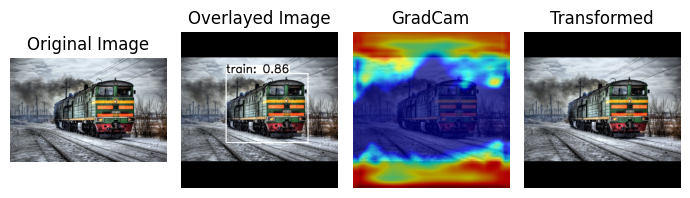

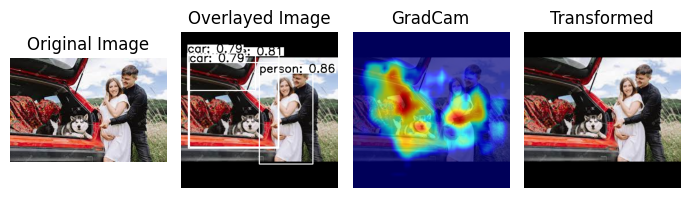

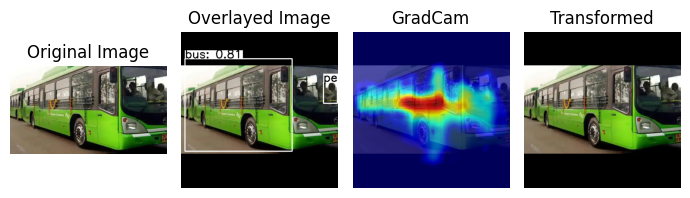

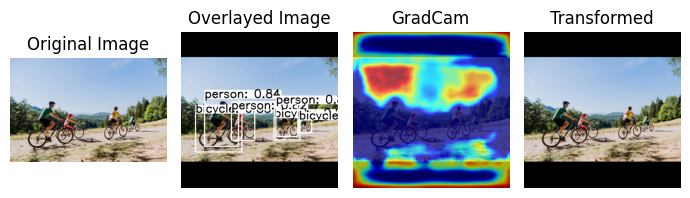

In [ ]:
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from typing import List

from pytorch_grad_cam.utils.image import show_cam_on_image
from parrotletml.mygradcam import YoloCAM
from parrotletml.utils import cells_to_bboxes, overlay_predictions, non_max_suppression

import glob

from parrotletml.utils import resize_image, normalize_image


scaled_anchors = torch.tensor(config.ANCHORS, device=config.DEVICE) * torch.tensor(
    config.S, device=config.DEVICE
).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)

cam = YoloCAM(model=ptmodel, target_layers=[ptmodel.layers[-3]], use_cuda=False)


# Define the preprocessing function for the input image
def preprocess_image(image):
    # # Read the image using OpenCV and convert to RGB
    # image = cv2.cvtColor(cv2.imread(impath, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    image = np.asarray(image)

    # Resize, normalize, and convert image to the required format
    image = resize_image(image, (416, 416), fill=(0, 0, 0))

    # image = np.expand_dims(normalize_cifar_cv_image(resize_image(impath, (32, 32)).transpose(2, 0, 1)).astype(np.float32), axis=0)
    # image = np.expand_dims(
    #     normalize_image(image, mean=[0, 0, 0], std=[1, 1, 1])
    #     .transpose(2, 0, 1)
    #     .astype(np.float32),
    #     axis=0,
    # )

    image = normalize_image(image, mean=[0, 0, 0], std=[1, 1, 1]).astype(np.float32)

    return image, torch.from_numpy(image.transpose(2, 0, 1))


@torch.inference_mode()
def predict(
    image: np.ndarray,
    iou_thresh: float = 0.5,
    thresh: float = 0.4,
    show_cam: bool = True,
    transparency: float = 0.3,
) -> List[np.ndarray]:
    # transformed_image = torch.tensor(
    #     config.transforms(image=image)["image"].unsqueeze(0), device=config.DEVICE
    # )

    # print(transformed_image.shape)

    image, transformed_image = preprocess_image(image)
    transformed_image = torch.tensor(transformed_image, device=config.DEVICE).unsqueeze(
        0
    )
    # print(transformed_image.shape)

    output = ptmodel(transformed_image)

    bboxes = [[] for _ in range(1)]
    for i in range(3):
        batch_size, A, S, _, _ = output[i].shape
        anchor = scaled_anchors[i]
        boxes_scale_i = cells_to_bboxes(
            torch.tensor(output[i], device=config.DEVICE), anchor, S=S, is_preds=True
        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box

    nms_boxes = non_max_suppression(
        bboxes[0],
        iou_threshold=iou_thresh,
        threshold=thresh,
        box_format="midpoint",
    )
    plot_img = np.clip(
        overlay_predictions(
            image,
            nms_boxes,
            class_labels=config.PASCAL_CLASSES,
            confidence_threshold=0.78,
        ),
        0,
        1,
    )
    if not show_cam:
        return [plot_img, image]

    grayscale_cam = cam(transformed_image, scaled_anchors)[0, :, :]
    # img = cv2.resize(image, (416, 416))
    # img = np.float32(img) / 255
    cam_image = show_cam_on_image(
        image,
        grayscale_cam,
        use_rgb=True,
        image_weight=transparency,
    )
    return [plot_img, image, cam_image]


import glob

if __name__ == "__main__":
    for p in glob.glob("samples/*.*g"):
        img_path = p  # "samples/ammar.jpg"
        image = np.array(Image.open(img_path))

        # image = resize_image(image, (416, 416), fill=(0, 0, 0))

        pimage = predict(image)

        # Create a figure with two subplots
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(
            1, 4, figsize=(7, 10)
        )  # Adjust fig size as needed

        # Plot the images in the subplots
        ax1.imshow(image)
        ax1.set_title("Original Image")
        ax1.axis("off")  # Turn off-axis labels and ticks

        # Plot the images in the subplots
        ax2.imshow(pimage[0])
        ax2.set_title("Overlayed Image")
        ax2.axis("off")  # Turn off-axis labels and ticks

        ax3.imshow(pimage[2])
        ax3.set_title("GradCam")
        ax3.axis("off")  # Turn off-axis labels and ticks

        ax4.imshow(pimage[1])
        ax4.set_title("Transformed")
        ax4.axis("off")  # Turn off-axis labels and ticks

        # Display the figure
        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()

    # cv2.imshow("image", image[0])